# Recursive Feature Selection using Gradient based and Tree based Estimators 

In [2]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\anjal\anaconda3\lib\site-packages (0.7.0)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
data = pd.read_csv('../data/profile_labelled.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.sample(10)

,gender,age,cust_id,became_member_on,days_as_member,income_in_k,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type
11929,M,20,5495db54251e492d989822a1444ac7d7,2018-01-07,1059,34.0,0.0,5.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,5.0,5.0,2.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0,1.0,11.56,5.000000,117.000000,0.0,17.0,0.60,0.000,2.31,0.004721,passive
14768,M,85,a65353ea28ff442aabfb39eb974326e3,2016-10-01,1522,96.0,3.0,3.0,3.0,7.0,3.0,1.0,2.0,3.0,2.0,1.0,3.0,1.0,2.0,3.0,2.0,1.0,0.0,3.0,1.0,2.0,3.0,2.0,1.0,0.0,189.86,11.666667,176.000000,20.0,20.0,1.00,1.000,27.12,0.004599,active
4853,M,30,5129a2a8e182466a9599c80e7226ea29,2015-01-10,2152,40.0,1.0,4.0,3.0,18.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,4.0,4.0,0.0,2.0,2.0,3.0,1.0,3.0,3.0,0.0,1.0,2.0,151.09,3.875000,132.000000,3.0,5.0,0.75,0.250,8.39,0.008364,active
11314,M,65,be630b1393a744798b87e3ef23f46aed,2016-01-27,1770,34.0,4.0,5.0,5.0,16.0,4.0,3.0,4.0,4.0,1.0,3.0,5.0,4.0,5.0,5.0,2.0,3.0,0.0,5.0,4.0,5.0,5.0,2.0,3.0,0.0,328.30,8.285714,166.285714,12.0,22.0,1.00,0.800,20.52,0.009040,active
4436,M,34,438754025de24239a4561429155a7e36,2018-04-15,961,41.0,0.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,5.0,6.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,11.55,10.000000,174.000000,0.0,21.0,0.33,0.000,2.89,0.004162,passive
7356,M,63,0bb50a84fe1040c69f941f6f34f751b2,2015-11-08,1850,70.0,4.0,6.0,4.0,10.0,4.0,2.0,4.0,4.0,2.0,2.0,6.0,3.0,5.0,5.0,2.0,3.0,1.0,4.0,3.0,4.0,3.0,2.0,1.0,1.0,195.57,6.500000,149.142857,15.0,20.0,0.67,0.667,19.56,0.005405,active
3479,F,37,9e473f9bd189408c8fcbb000822f59e6,2016-02-16,1750,57.0,4.0,4.0,2.0,10.0,4.0,2.0,4.0,4.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,132.03,6.600000,153.600000,15.0,15.0,0.50,1.000,13.20,0.005714,passive
6817,F,65,953f730903484691800d77f17750cdb0,2018-01-28,1038,39.0,2.0,6.0,3.0,9.0,2.0,1.0,2.0,2.0,1.0,1.0,6.0,4.0,5.0,6.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,1.0,2.0,0.0,100.40,9.090909,194.181818,7.0,29.0,0.50,0.333,11.16,0.008671,passive
395,M,69,7170e85765bb4fd580035c6469620252,2015-06-22,1989,62.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,1.0,1.0,5.0,4.0,5.0,5.0,2.0,2.0,1.0,5.0,4.0,5.0,5.0,2.0,2.0,1.0,91.47,5.833333,136.000000,8.0,21.0,1.00,0.400,18.29,0.002514,active
3078,M,51,9e894ff66aba45bbbe75575a03aeb00e,2017-03-13,1359,104.0,5.0,6.0,4.0,8.0,5.0,3.0,4.0,5.0,2.0,3.0,6.0,4.0,5.0,5.0,2.0,3.0,1.0,4.0,4.0,4.0,3.0,2.0,1.0,1.0,225.42,9.400000,145.600000,30.0,30.0,0.67,0.833,28.18,0.005887,active


In [5]:
# define dataset
gen_split = pd.get_dummies(data['gender'], prefix='is_')
data = pd.concat([data, gen_split], axis=1)
data.drop('gender', axis=1, inplace=True)
data.sample(10)

,age,cust_id,became_member_on,days_as_member,income_in_k,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,customer_type,is__F,is__M,is__O
4925,69,b857481919e44cf29b036eca3217d2da,2017-10-30,1128,72.0,5.0,6.0,4.0,12.0,5.0,3.0,4.0,5.0,2.0,3.0,6.0,4.0,5.0,5.0,2.0,3.0,1.0,4.0,4.0,4.0,3.0,2.0,1.0,1.0,268.68,8.000000,160.000000,19.0,19.0,0.67,0.833,22.39,0.010638,active,0,1,0
6602,65,a0ae43a9b2d343e19a7cddb9c07353bd,2018-01-10,1056,30.0,0.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,5.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,0.0,1.0,1.0,18.83,7.142857,150.857143,0.0,17.0,0.40,0.000,6.28,0.002841,passive,0,1,0
9313,65,be429cad6b054990a4926ea40bf779df,2018-06-17,898,72.0,2.0,5.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,5.0,1.0,5.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,28.63,6.875000,186.000000,7.0,14.0,0.20,0.400,14.32,0.002227,passive,1,0,0
1779,84,469227d170274de18bf33e6bebe8bcd0,2016-09-07,1546,66.0,4.0,5.0,5.0,6.0,4.0,2.0,3.0,3.0,3.0,1.0,5.0,2.0,4.0,4.0,4.0,1.0,0.0,5.0,2.0,4.0,4.0,4.0,1.0,0.0,90.50,9.285714,173.142857,25.0,30.0,1.00,0.800,15.08,0.003881,active,1,0,0
14155,60,34c0f36f5f504ead86c1378c7d41d8f6,2017-10-07,1151,35.0,0.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,5.0,6.0,1.0,4.0,1.0,4.0,2.0,3.0,4.0,0.0,3.0,1.0,6.62,9.500000,196.800000,0.0,16.0,0.67,0.000,3.31,0.001738,passive,1,0,0
6383,67,71d3c278485543f4a7e4f5581f4414e5,2018-01-03,1063,71.0,4.0,5.0,4.0,6.0,4.0,2.0,3.0,4.0,1.0,3.0,5.0,2.0,4.0,5.0,1.0,3.0,1.0,4.0,2.0,3.0,4.0,1.0,2.0,1.0,150.49,10.769231,179.076923,19.0,19.0,0.80,0.800,25.08,0.005644,active,1,0,0
4889,50,2e8155ddda4f4f6683b9759ced75431f,2018-07-22,863,41.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,9.52,0.000000,84.000000,0.0,0.0,0.33,0.000,4.76,0.002317,passive,0,1,0
8823,64,882346bfc610473c8505199a5179d302,2017-09-10,1178,69.0,1.0,3.0,3.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,508.74,7.142857,140.571429,2.0,12.0,1.00,0.333,127.18,0.003396,active,0,1,0
9441,52,2c4e9f96a5ac4df69ba3b26c194ab5b7,2016-12-10,1452,106.0,0.0,4.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,3.0,0.0,1.0,3.0,2.0,1.0,2.0,1.0,0.0,0.0,2.0,127.88,3.333333,112.000000,0.0,5.0,0.50,0.000,25.58,0.003444,passive,0,1,0
16,33,c6c9884912c645429f3333f912b55f44,2017-09-26,1162,52.0,1.0,6.0,3.0,9.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,2.0,5.0,6.0,1.0,5.0,0.0,3.0,2.0,3.0,3.0,0.0,3.0,0.0,17.90,9.900000,196.800000,2.0,19.0,0.50,0.167,1.99,0.007745,passive,1,0,0


## Finding set of correlated features

In [6]:
correlated_features = set()
correlation_matrix = data[['is__F', 'is__M', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

{'is__M'}

## Adding label

In [7]:
data['customer_type'] = "passive"
data.loc[(data['total_view_ratio'] >= 0.6) & (data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
data['customer_type'].value_counts()

active     9637
passive    5188
Name: customer_type, dtype: int64

## Set X as Input features and y as target label

In [8]:
X = data[['is__F','is__M', 'is__O', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = data['customer_type']


## Split Data to Training and Testing Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [10]:
#Print the shape of training and test data
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (11118, 10)
X_test:  (3707, 10)


## Running RFECV

In [11]:
#RFECV automatically selects the number of features
#Checking with Random Forest Classifier model
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='accuracy')
pipeline = Pipeline(steps=[('s',rfecv),('m',model)])

pipeline.fit(X_train, y_train)

print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Feature selection array: ', rfecv.support_)
print('Feature Ranking: ',rfecv.ranking_)

Optimal number of features: 4
Feature selection array:  [False False False False False  True False  True  True  True]
Feature Ranking:  [6 5 7 4 3 1 2 1 1 1]


In [12]:
#evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('F1 Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

F1 Score: 0.720 (0.012)


## Plotting the RFECV curve for the model with best accuracy

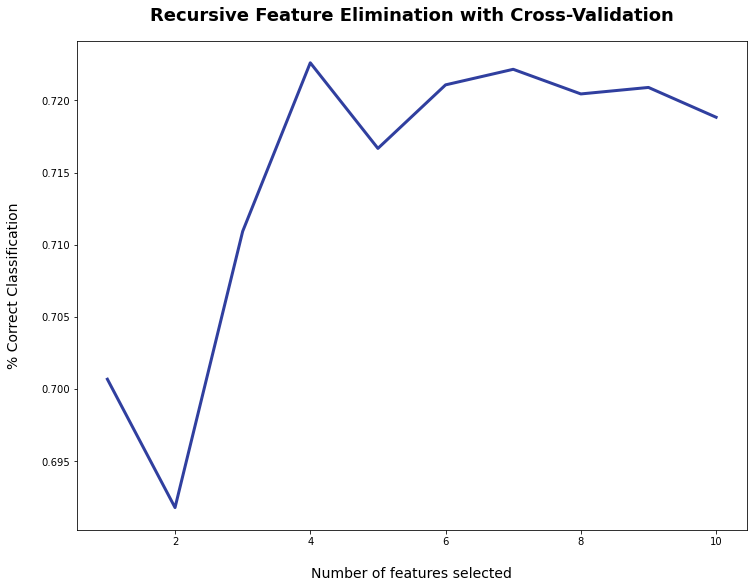

In [13]:
plt.figure(figsize=(12, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [14]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

#Dropping the non-required features from training and test data
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[0 1 2 3 4 6]


In [15]:
#Print features and feature importance
print("Features: ", X_train.columns)
print("Feature Importance: ", rfecv.estimator_.feature_importances_)

Features:  Index(['avg_difficulty', 'avg_transaction_amt',
       'transactions_per_membership_days', 'days_as_member'],
      dtype='object')
Feature Importance:  [0.17415313 0.39733108 0.26286711 0.16564869]


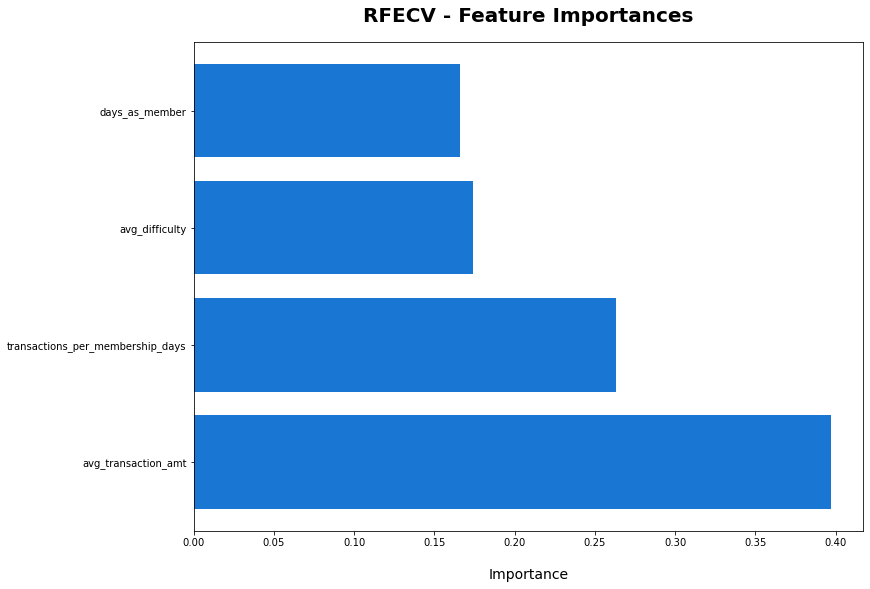

In [16]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(12, 9))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
X = data[['is__F', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = target
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
X = data[['is__F', 'age', 'income_in_k', 'avg_difficulty', 'avg_duration', 'avg_transaction_amt', 'transactions_per_membership_days', 'days_as_member']]
y = target
# create pipeline
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

## Check if data is balanced

In [17]:
y_train.value_counts()

active     7240
passive    3878
Name: customer_type, dtype: int64

In [18]:
#Find percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

active     65.12
passive    34.88
Name: customer_type, dtype: float64

#### The target classes are imbalanced!

### SMOTE

In [19]:
#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [20]:
#check percentage distribution
round((y_train.value_counts()/y_train.count())*100,2)

passive    50.0
active     50.0
Name: customer_type, dtype: float64

In [21]:
y_train.value_counts()

passive    7240
active     7240
Name: customer_type, dtype: int64

In [ ]:
#Changing active to 1 and passive to 0 to get f1 score
#Training data
y_train = y_train.replace(to_replace='active', value= 1)
y_train = y_train.replace(to_replace='passive', value= 0)

#Testing data
y_test = y_test.replace(to_replace='active', value= 1)
y_test = y_test.replace(to_replace='passive', value= 0)

In [23]:
y_train

0        1
1        0
2        1
3        1
4        0
        ..
14475    0
14476    0
14477    0
14478    0
14479    0
Name: customer_type, Length: 14480, dtype: int64

## Modeling and Prediction

In [24]:
#Use GridSearchCV to fit selected classifiers to compare the efficiencies of different models
def train_classifier(classifier, hyperparameters, X, y): 
    gridsearch = GridSearchCV(estimator=classifier, param_grid = hyperparameters, cv=5, verbose=1, scoring = 'f1')
    model_train = gridsearch.fit(X, y)
    print(classifier.__class__.__name__)
    print("Mean Accuracy:", round(model_train.score(X, y),4))
    print("F1: ",gridsearch.best_score_)
    return gridsearch.best_estimator_

In [25]:
# Initialize classification algorithms
# LogisticRegression
lor = LogisticRegression(random_state=42)
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=42) 
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42) 
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42) 

classification_algs = [lor,rfc,abc,gbc]
classifier_dict={}

for classifier in classification_algs:
    #training with no hyperparameters
    best_est = train_classifier(classifier,{}, X_train, y_train)
    #classifier_dict[classifier] = best_est

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression
Mean Accuracy: 0.6749
F1:  0.6738484089902751
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished


RandomForestClassifier
Mean Accuracy: 1.0
F1:  0.7934195735395865
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


AdaBoostClassifier
Mean Accuracy: 0.773
F1:  0.7649672775850102
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


GradientBoostingClassifier
Mean Accuracy: 0.7935
F1:  0.7795834349438612


#### Highest f1 score is obtained for Gradient Boosting Classifier

## Fine Tuning the Model

In [26]:
#Tuning the RandomForestClassifier with hyperparameters to improve the accuracy score
hyperparameters = {'n_estimators': [120],#[100, 120, 300, 500, 800, 1200], #sets the number of decision trees to be used in the forest
                  'max_depth': [8],#[5, 8, 15, 25, 30, None], #sets the max depth of the tree
                  'min_samples_split': [2],#[1,2,5,10,15,100], #The minimum number of samples needed before a split
                  'min_samples_leaf': [1]#[1,2,5,10], #The minimum number of samples needed to create a leaf (decision) node
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_est = train_classifier(rfc, hyperparameters, X_train, y_train)
print(rfc_best_est)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.2s finished


RandomForestClassifier
Mean Accuracy: 0.8061
F1:  0.7813014779843354
RandomForestClassifier(max_depth=8, n_estimators=120, random_state=42)


In [27]:
#Feature importances given by the best estimate RandomForestClassfier
rfc_best_est.feature_importances_

array([0.06249011, 0.55100812, 0.25837414, 0.12812763])

In [ ]:
#Tuning the GradientBoostingClassifier with hyperparameters to improve the accuracy score
#learning_rate; default=0.1; shrinks the contribution of each tree by learning_rates
lr = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

#n_estimators, default=100, number of boosting stages to perform
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#max_depth, default=3, maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree
max_depths = np.linspace(1, 32, 32, endpoint=True)

#min_samples_split, default=2, The minimum number of samples required to split an internal node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

#min_samples_leaf, default=1,The minimum number of samples required to be at a leaf node.
min_samples_leaf=np.linspace(0.1, 0.5, 5, endpoint=True)

#max_features{‘auto’, ‘sqrt’, ‘log2’}, default=None, The number of features to consider when looking for the best split:
max_features = list(range(1,X_train.shape[1]))

gb_tuned = GradientBoostingClassifier(random_state=42)
hyperparameters = {'learning_rate': [0.5], 'n_estimators': [200], 'max_depth': max_depths}#, 'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features}   
gb_best_est = train_classifier(gb_tuned, hyperparameters, X_train, y_train)
print(gb_best_est)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


## Predict

In [ ]:
#Print the shape of test data
print(X_test.shape)
print(y_test.shape)

In [ ]:
#Passing the test data to the GradientBoodtingClassifier estimator
y_pred = gb_best_est.predict(X_test)
y_pred

## Measuring Performance of Classification

### Confusion Matrix 

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

In [ ]:
#Get True Negative tn, False Positive FP, False Negative FN, True Positive values from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('(tn, fp, fn, tp) : ', (tn, fp, fn, tp))

In [ ]:
#f1 score of predicted data
f1_score = f1_score(y_test, y_pred)
print('F1 score of Model Prediction: ', f1_score)

In [ ]:
#Plot the confusion Matrix
sns.heatmap(cf_matrix, annot=True)

In [ ]:
#Confusion Matrix plotted with Percentage values
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')